# Financial News Extraction Pipeline

## Overview
This notebook contains an institutional-grade news fetcher designed to extract high-signal financial news for a set of companies over a specific period (like 30 days), categorise them, and output a structured JSON.

## Input
- `tickers`: A list of 25 companies, e.g., `["TSLA", "NVDA", "AAPL", ...]`
- `days`: Number of days to fetch news for (30 days by default).

## Logic
1. **Financial Intent Classifier**: Categorizes extracted news into targeted buckets (earnings, analyst, management, corporate, regulation, etc.)
2. **Source Credibility Weighting**: Boosts scores for premium sources like Reuters, Bloomberg, WSJ.
3. **Semantic Similarity Filter**: Filters out non-financial noise using local dense embeddings (`all-MiniLM-L6-v2`).
4. **Categorization & Pagination**: Limits news per category to avoid spam and focuses only on high-quality articles.

## Output
A hierarchical JSON document containing:
```json
{
   "TICKER": {
      "news_count": 10,
      "30_day_news": {
         "YYYY-MM-DD": {
             "category_name": [
                  { "title": "...", "summary": "...", "source": "..." }
             ]
         }
      }
   }
}
```
This JSON can directly be used to feed into an LLM context window to generate analytical summaries (.join(['probabilities', 'bull/bear case'])) per day or overall.

In [1]:
import feedparser
import requests
import re
import yfinance as yf
from datetime import datetime, timedelta
import time
import ssl
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
import json

# SSL Fix
if hasattr(ssl, '_create_unverified_context'):
    ssl._create_default_https_context = ssl._create_unverified_context

# ============================================================
# UPGRADE 3: SEMANTIC SIMILARITY FILTER
# ============================================================

try:
    from sentence_transformers import SentenceTransformer, util
    SEMANTIC_MODEL = SentenceTransformer("all-MiniLM-L6-v2")
    FINANCE_REFERENCE = "earnings revenue guidance profit loss merger acquisition regulation lawsuit analyst rating upgrade downgrade CEO CFO quarterly results forecast dividend buyback IPO"
    REF_EMBEDDING = SEMANTIC_MODEL.encode(FINANCE_REFERENCE)
    SEMANTIC_ENABLED = True
    print("Semantic filter: ENABLED")
except ImportError:
    SEMANTIC_ENABLED = False
    print("Semantic filter: DISABLED (sentence-transformers not installed)")

# ============================================================
# UPGRADE 1: FINANCIAL INTENT CLASSIFIER
# ============================================================

CATEGORY_RULES = {
    "earnings": ["earnings", "eps", "revenue", "quarter", "results", "guidance", "forecast", "profit", "loss", "beat", "miss"],
    "analyst": ["upgrade", "downgrade", "price target", "rating", "initiated", "reiterate", "analyst"],
    "management": ["ceo", "cfo", "board", "resigns", "appoints", "executive", "leadership"],
    "corporate": ["acquisition", "merger", "buyback", "dividend", "split", "deal", "partnership", "expansion"],
    "filing": ["13f", "stake", "holdings", "llc increases", "llc reduces", "management purchased", "increases position", 
               "reduces position", "institutional", "buys shares", "sells shares", "buys new shares", "new position in"],
    "regulation": ["sec", "lawsuit", "settlement", "investigation", "fine", "penalty", "compliance"],
}

# Categories to KEEP (high signal)
KEEP_CATEGORIES = ["earnings", "analyst", "management", "corporate", "regulation"]

# Categories to DISCARD (low signal, high noise)
DISCARD_CATEGORIES = ["filing"]

# Ownership spam patterns (HARD BLOCK)
OWNERSHIP_SPAM_PATTERNS = [
    "buys shares", "sells shares", "buys new shares", "increases holdings",
    "reduces holdings", "new position in", "llc buys", "llc sells",
    "advisors buys", "advisors sells", "management increases", "management reduces",
    "grows stock holdings", "raises stock position", "sells 4,", "sells 3,", "sells 2,", "sells 1,"
]

def is_ownership_spam(text):
    """Returns True if article is ownership/institutional filing spam."""
    text_lower = text.lower()
    return any(pattern in text_lower for pattern in OWNERSHIP_SPAM_PATTERNS)

def classify_article(text):
    """
    Classifies article into financial categories.
    Returns the primary category or 'general'.
    """
    text_lower = text.lower()
    scores = {}
    
    for category, keywords in CATEGORY_RULES.items():
        score = sum(1 for kw in keywords if kw in text_lower)
        if score > 0:
            scores[category] = score
    
    if not scores:
        return "general"
    
    return max(scores, key=scores.get)

# ============================================================
# UPGRADE 2: SOURCE CREDIBILITY WEIGHTING
# ============================================================

SOURCE_WEIGHT = {
    "reuters": 5,
    "wsj": 5,
    "ft.com": 5,
    "bloomberg": 5,
    "cnbc": 4,
    "seekingalpha": 3,
    "yahoo": 3,
    "benzinga": 2,
    "marketwatch": 2,
    "nasdaq": 2,
    "stocktwits": 0,
    "google": 1,  # Google News aggregates, variable quality
}

def get_source_weight(link, source_name):
    """Returns credibility weight based on source."""
    link_lower = link.lower()
    source_lower = source_name.lower()
    
    for source, weight in SOURCE_WEIGHT.items():
        if source in link_lower or source in source_lower:
            return weight
    
    return 1  # Default weight

# ============================================================
# UPGRADE 4: STRONGER NOISE BLACKLIST
# ============================================================

NOISE_KEYWORDS = [
    # Weather
    "weather", "storm", "hurricane", "flood", "tornado", "freeze", "snow",
    # Violence/Crime
    "shooting", "murder", "crime", "arrest", "police",
    # War/Military
    "war", "military", "invasion", "troops", "missile", "ukraine", "russia",
    # Politics (unless directly business-related)
    "election", "vote", "congress", "senate", "democrat", "republican", "trump", "biden",
    # Sports/Entertainment
    "sports", "game", "celebrity", "movie", "concert", "nfl", "nba",
    # Travel disruptions
    "airline delays", "flight cancel", "airport",
    # Crypto-only noise (unless it's about the company's crypto strategy)
    "bitcoin price", "crypto crash", "meme coin",
]

def has_noise(text):
    """Returns True if article contains noise keywords."""
    text_lower = text.lower()
    noise_count = sum(1 for kw in NOISE_KEYWORDS if kw in text_lower)
    return noise_count >= 2  # Allow 1 mention, block 2+

# ============================================================
# LAYER 1: SOURCE SEPARATION (Tier A = ticker-specific only)
# ============================================================

def get_rss_feeds(ticker):
    """
    Returns ONLY high-quality ticker-specific feeds.
    Removed all generic macro noise sources.
    """
    return [
        # Tier A: Ticker-specific (HIGH RELEVANCE)
        f"https://news.google.com/rss/search?q={ticker}+stock&hl=en-US&gl=US&ceid=US:en",
        f"https://feeds.finance.yahoo.com/rss/2.0/headline?s={ticker}",
        f"https://www.nasdaq.com/feed/rssoutbound?symbol={ticker}",
        f"https://stocktwits.com/symbol/{ticker}.rss",
        f"https://seekingalpha.com/api/sa/combined/{ticker}.xml",
        
        # Tier B: Quality sources (will be filtered by ticker presence)
        "https://feeds.benzinga.com/benzinga",
        "https://seekingalpha.com/market_currents.xml",
    ]

# ============================================================
# COMPANY NAME LOOKUP
# ============================================================

_company_cache = {}

def get_company_info(ticker):
    """Returns company name and related keywords for filtering."""
    if ticker in _company_cache:
        return _company_cache[ticker]
    
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        
        company_name = info.get('shortName', '') or info.get('longName', '')
        
        keywords = [ticker.lower()]
        
        if company_name:
            keywords.append(company_name.lower())
            for word in company_name.split():
                if len(word) > 3:
                    keywords.append(word.lower())
        
        _company_cache[ticker] = keywords
        return keywords
        
    except Exception:
        _company_cache[ticker] = [ticker.lower()]
        return [ticker.lower()]

# ============================================================
# HIGH IMPACT KEYWORDS
# ============================================================

HIGH_IMPACT_KEYWORDS = [
    "earnings", "revenue", "guidance", "quarter", "profit", "loss",
    "upgrade", "downgrade", "beat", "miss", "forecast", "outlook",
    "acquisition", "merger", "buyback", "dividend", "split",
    "sec", "filing", "lawsuit", "settlement", "investigation",
    "ceo", "cfo", "executive", "board", "analyst"
]

# ============================================================
# RELEVANCE FILTER (HARD FILTER)
# ============================================================

def is_relevant(article, ticker, company_keywords):
    """HARD FILTER: Returns True only if article is company-specific."""
    text = (article["title"] + " " + article.get("summary", "")).lower()
    
    for kw in company_keywords:
        if kw in text:
            return True
    
    return False

# ============================================================
# UPGRADE 3: SEMANTIC SIMILARITY SCORE
# ============================================================

def semantic_score(text):
    """Returns semantic similarity to financial reference text."""
    if not SEMANTIC_ENABLED:
        return 1.0  # Bypass if not available
    
    try:
        emb = SEMANTIC_MODEL.encode(text[:500])  # Limit text length
        score = util.cos_sim(emb, REF_EMBEDDING).item()
        return score
    except Exception:
        return 0.5

# ============================================================
# COMPLETE SCORING FUNCTION
# ============================================================

def score_article(article, ticker, company_keywords):
    """
    PRO scoring with all upgrades:
    - Ticker/company presence
    - High-impact keywords
    - Source credibility
    - Semantic similarity
    - Category bonuses
    - Noise penalties
    """
    score = 0
    title = article["title"].lower()
    text = (title + " " + article.get("summary", "")).lower()
    link = article.get("link", "").lower()
    source = article.get("source", "")
    
    # === BASE SCORING ===
    
    # Ticker in title: +10 (strongest signal)
    if ticker.lower() in title:
        score += 10
    elif ticker.lower() in text:
        score += 5
    
    # Company name match: +6
    for kw in company_keywords:
        if kw != ticker.lower() and kw in text:
            score += 6
            break
    
    # High-impact keywords: +2 each (max 8)
    impact_count = sum(1 for k in HIGH_IMPACT_KEYWORDS if k in text)
    score += min(impact_count * 2, 8)
    
    # === UPGRADE 2: Source credibility ===
    score += get_source_weight(link, source)
    
    # === UPGRADE 3: Semantic similarity bonus ===
    if SEMANTIC_ENABLED:
        sem_score = semantic_score(text)
        if sem_score > 0.35:
            score += 5
        elif sem_score > 0.25:
            score += 2
        elif sem_score < 0.15:
            score -= 5  # Penalize non-financial content
    
    # === UPGRADE 1: Category bonuses ===
    category = classify_article(text)
    article['_category'] = category  # Store for quota system
    
    if category in ["earnings", "analyst"]:
        score += 4
    elif category in ["management", "corporate"]:
        score += 3
    elif category in ["regulation"]:
        score += 2
    elif category in ["filing"]:
        score -= 8  # Heavy penalty for ownership spam
    
    # === UPGRADE 4: Noise penalties ===
    if has_noise(text):
        score -= 10
    
    return score

# ============================================================
# DEDUPLICATION
# ============================================================

def deduplicate_articles(articles):
    """Deduplicates articles based on normalized title similarity."""
    unique_articles = []
    seen_normalized_titles = set()
    
    for article in articles:
        norm_title = re.sub(r'\W+', '', article['title'].lower())
        
        # More aggressive dedup: first 50 chars
        short_key = norm_title[:50]
        
        if short_key in seen_normalized_titles:
            continue
            
        seen_normalized_titles.add(short_key)
        unique_articles.append(article)
        
    return unique_articles

# ============================================================
# UPGRADE 5: CATEGORY QUOTAS
# ============================================================

def apply_category_quotas(articles, quota_per_category=5, total_limit=50):
    """
    Returns balanced articles with max N per category.
    Ensures diverse summary (Bloomberg style).
    """
    bucket = defaultdict(list)
    
    for article in articles:
        category = article.get('_category', 'general')
        bucket[category].append(article)
    
    final = []
    
    # Priority order
    priority_categories = ["earnings", "analyst", "corporate", "management", "regulation", "general"]
    
    for cat in priority_categories:
        if cat in bucket:
            final.extend(bucket[cat][:quota_per_category])
    
    # Fill remaining with any leftover high-scoring articles
    if len(final) < total_limit:
        all_remaining = [a for a in articles if a not in final]
        final.extend(all_remaining[:total_limit - len(final)])
    
    return final[:total_limit]

# ============================================================
# MAIN FETCH FUNCTION (with all 5 upgrades)
# ============================================================

def fetch_news_data(ticker, days=30):
    """
    INSTITUTIONAL-GRADE news fetcher with 5 upgrades:
    1. Financial intent classifier
    2. Source credibility weighting
    3. Semantic similarity filter
    4. Stronger noise blacklist
    5. Category quotas
    """
    feeds = get_rss_feeds(ticker)
    cutoff_date = datetime.now() - timedelta(days=days)
    
    company_keywords = get_company_info(ticker)
    
    raw_articles = []
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36'
    }

    def fetch_single_feed(rss_url):
        articles = []
        try:
            response = requests.get(rss_url, headers=headers, timeout=5)
            if response.status_code != 200:
                return []
            
            feed = feedparser.parse(response.content)

            for entry in feed.entries:
                published_dt = None
                if hasattr(entry, 'published_parsed') and entry.published_parsed:
                    published_dt = datetime.fromtimestamp(time.mktime(entry.published_parsed))
                elif hasattr(entry, 'updated_parsed') and entry.updated_parsed:
                    published_dt = datetime.fromtimestamp(time.mktime(entry.updated_parsed))
                
                if not published_dt or published_dt < cutoff_date:
                    continue

                title = entry.title if hasattr(entry, 'title') else ''
                link = entry.link if hasattr(entry, 'link') else ''
                summary = entry.summary if hasattr(entry, 'summary') else ''
                
                def clean_text(text):
                    if not text: return ""
                    text = re.sub(r'<[^>]+>', '', text)
                    text = text.replace("&nbsp;", " ").replace("&amp;", "&")
                    return " ".join(text.split())

                title = clean_text(title)
                summary = clean_text(summary)
                
                if len(summary) < 20:
                    summary = title
                    
                source_title = getattr(feed.feed, 'title', 'Unknown')

                articles.append({
                    'title': title,
                    'link': link,
                    'published': published_dt.strftime('%Y-%m-%d %H:%M:%S'),
                    'summary': summary,
                    'source': source_title
                })
        except Exception:
            pass
            
        return articles

    # Parallel fetch
    with ThreadPoolExecutor(max_workers=8) as executor:
        future_to_url = {executor.submit(fetch_single_feed, url): url for url in feeds}
        for future in as_completed(future_to_url):
            try:
                data = future.result()
                raw_articles.extend(data)
            except Exception:
                pass
    
    # Deduplicate
    articles = deduplicate_articles(raw_articles)
    
    # Hard ticker filter
    articles = [a for a in articles if is_relevant(a, ticker, company_keywords)]
    
    # Remove noise
    articles = [a for a in articles if not has_noise(a["title"] + " " + a.get("summary", ""))]
    
    # Score and rank
    for article in articles:
        article['_score'] = score_article(article, ticker, company_keywords)
    
    articles.sort(key=lambda x: x['_score'], reverse=True)
    
    # Apply category quotas
    top_articles = apply_category_quotas(articles, quota_per_category=5, total_limit=50)
    
    return top_articles

/Users/koustavsarkar/Documents/mba_projects/AcuTrader-backend/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Semantic filter: ENABLED


## Generating the Extracted Output
The target output is a nested dictionary mapping each company to its 30-day news breakdown. We iterate over the 25 requested symbols and collect the data into the requested shape.

In [2]:
COMPANIES = [
    "TSLA", "NVDA", "AAPL", "AMD",  "AMZN", "MSFT", "GOOGL", "META", 
    "BAC", "INTC", "CSCO", "KO", "XOM", 
     "NFLX", "NKE",
]

def extract_daily_categorical_news(tickers, days=30):
    all_companies_data = {}
    
    for ticker in tickers:
        print(f"Fetching data for {ticker}...")
        articles = fetch_news_data(ticker, days=days)
        
        # Structure: date -> category -> list of articles
        daily_news = defaultdict(lambda: defaultdict(list))
        
        for idx, a in enumerate(articles):
            # publish format: YYYY-MM-DD HH:MM:SS
            pub_date = a['published'].split(' ')[0]
            
            # Re-fetch category if we want, or fall back to '_category'. 
            # Our implementation retains `_category`.
            category = a.get('_category', 'general')
            
            # Store simplified representation for JSON output
            daily_news[pub_date][category].append({
        
                "summary": a['summary'],
                "source": a['source'],
               
            })

        all_companies_data[ticker] = {
            "news_count": len(articles),
            "30_day_news": { date: dict(categories) for date, categories in daily_news.items() }
        }
        
    return all_companies_data

# Set list for a quick test run to first 2 companies, to fetch actual complete output use `COMPANIES` list.
output_data = extract_daily_categorical_news(COMPANIES, days=30)

# Print out the result JSON as requested
# To avoid massive console logs, we write to a file first. We then print an excerpt.
with open("companies_30_day_categorical_news.json", "w") as f:
    json.dump(output_data, f, indent=4)
    
print(f"Processed extraction for {len(COMPANIES)} companies. Saved to companies_30_day_categorical_news.json")

Fetching data for TSLA...
Fetching data for NVDA...
Fetching data for AAPL...
Fetching data for AMD...
Fetching data for AMZN...
Fetching data for MSFT...
Fetching data for GOOGL...
Fetching data for META...
Fetching data for BAC...
Fetching data for INTC...
Fetching data for CSCO...
Fetching data for KO...
Fetching data for XOM...
Fetching data for NFLX...
Fetching data for NKE...
Processed extraction for 15 companies. Saved to companies_30_day_categorical_news.json


## Step 2: Text to Numerical Scoring & Ranking
We will now take the extracted json output from above, and transform the text (title + summary) into numerical representations using `all-MiniLM-L6-v2` (SentenceTransformer).
We'll compute a relevance/impact score against predefined financial keywords, rank the daily news based on this numerical score, and store the updated data.

In [3]:
from sentence_transformers import SentenceTransformer, util
import torch
import json

# 1. Load the model
# all-MiniLM-L6-v2 is an excellent balance of speed and performance for semantic similarity.
print("Loading SentenceTransformer model...")
model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Define Reference Embeddings
# We define what a 'High Impact' article looks like for stock movement.
HIGH_IMPACT_PHRASES = [
    "Better than expected earnings revenue beat growth surge",
    "Analyst upgrade price target increase buy rating",
    "Major acquisition merger buyout new partnership",
    "Unexpected CEO resignation leadership change",
    "SEC investigation lawsuit regulatory penalty"
]
reference_embeddings = model.encode(HIGH_IMPACT_PHRASES, convert_to_tensor=True)

def compute_semantic_score( summary):
    """
    Embeds the text and computes the maximum cosine similarity
    against the predefined high-impact phrases.
    """
    text = f"{summary}"
    text_embedding = model.encode(text, convert_to_tensor=True)
    
    # Compute cosine similarities
    cosine_scores = util.cos_sim(text_embedding, reference_embeddings)
    
    # Return the highest similarity score (0 to 1)
    max_score = torch.max(cosine_scores).item()
    return round(max_score, 4)

# 3. Load the data (or use the variable from the previous cell)
try:
    with open("companies_30_day_categorical_news.json", "r") as f:
        news_data = json.load(f)
    print("Loaded JSON data for scoring.")
except FileNotFoundError:
    print("Using in-memory output_data for scoring.")
    news_data = output_data  # defined in previous cell

def rank_and_score_news(data):
    """
    Iterates through the structured JSON, computes semantic scores,
    and sorts them descending per day per category.
    """
    print("Computing semantic scores and ranking...")
    # Recreate a new dictionary to avoid mutating while iterating if needed,
    # but we can also update in place.
    for ticker, ticker_data in data.items():
        # if "14_day_news" in ticker_data:
        # Let's find the correct key dynamically (14_day_news or 30_day_news)
        news_key = next((k for k in ticker_data.keys() if "_news" in k), None)
        if not news_key:
            continue
            
        for date, categories in ticker_data[news_key].items():
            for category, articles in categories.items():
                # Score each article
                for article in articles:
                    score = compute_semantic_score( article['summary'])
                    article['semantic_score'] = score
                
                # Sort articles by semantic score descending
                articles.sort(key=lambda x: x['semantic_score'], reverse=True)
    return data

# 4. Apply the scoring and ranking
ranked_news_data = rank_and_score_news(news_data)

# 5. Save the final ranked JSON
with open("companies_ranked_news.json", "w") as f:
    json.dump(ranked_news_data, f, indent=4)

print("Scoring and ranking complete. Saved to companies_ranked_news.json")


Loading SentenceTransformer model...
Loaded JSON data for scoring.
Computing semantic scores and ranking...
Scoring and ranking complete. Saved to companies_ranked_news.json


## Step 3: Daily Signal Aggregation & Classification Layer

### Input
`companies_ranked_news.json` — output from **Step 2**.  
Schema: `{ TICKER: { '30_day_news': { DATE: { CATEGORY: [ articles ] } } } }`  
Each article contains:
- `summary` — cleaned article text used for TextBlob sentiment
- `semantic_score` — cosine similarity to high-impact financial phrases (Step 2)
- `CATEGORY` key (e.g., `'earnings'`, `'analyst'`, `'regulation'`) — set by Rule-Based Intent Classifier in Step 1

### What This Step Does
For every `(ticker, date)` pair, aggregates all article-level data into **one structured row** of numerical features, then applies threshold rules to emit a **final classification label**.

| Feature | Method | Output |
|---|---|---|
| `avg_sentiment_polarity` | **TextBlob** lexicon-based polarity averaged over the day | float  -1.0 → 1.0 |
| `avg_semantic_impact` | Mean `semantic_score` from Step 2 | float  0.0 → 1.0 |
| `total_signals` | Article count for the day | int |
| `earnings_count` | **Rule-Based Intent Classifier** | int |
| `analyst_count` | **Rule-Based Intent Classifier** | int |
| `management_count` | **Rule-Based Intent Classifier** | int |
| `corporate_count` | **Rule-Based Intent Classifier** | int |
| `regulation_count` | **Rule-Based Intent Classifier** | int |
| `general_count` | **Rule-Based Intent Classifier** | int |
| **`daily_signal_label`** | **Classification Output** | **Bullish / Bearish / Neutral** |

### Classification Rule
```
Bullish  →  avg_sentiment_polarity > 0.05  AND  avg_semantic_impact > 0.25
Bearish  →  avg_sentiment_polarity < -0.05  OR  regulation_count >= 2
Neutral  →  everything else
```

### Output
`daily_structured_signals.csv` — one labelled row per `(ticker, date)`, ready for downstream ML models.

In [4]:
import subprocess, sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "textblob", "-q"])
from textblob import TextBlob



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [7]:
# ─────────────────────────────────────────────────────────────────────────────
# AGGREGATION — ONE FINAL ROW PER COMPANY (30-DAY ROLLUP)
# Each row represents aggregated news intelligence for a ticker across
# the full 30-day lookback window.
# ─────────────────────────────────────────────────────────────────────────────
def aggregate_30day_company_signals(data: dict) -> pd.DataFrame:
    """
    Aggregates all news articles across the full 30-day window per company.
    Output: ONE ROW PER TICKER with final signal label.

    Features:
      - Total article count (30 days)
      - Avg TextBlob sentiment polarity
      - Avg semantic impact
      - Intent bucket counts (earnings, analyst, regulation, etc.)
      - Final classification label (Bullish / Bearish / Neutral)
    """
    records = []

    for ticker, ticker_data in data.items():
        news_key = next((k for k in ticker_data if "_news" in k), None)
        if not news_key:
            continue

        sentiment_vals = []
        semantic_vals  = []
        intent_counts  = {b: 0 for b in INTENT_BUCKETS}

        # ── Aggregate ALL dates inside 30-day window ──────────────────────
        for _, categories in ticker_data[news_key].items():
            for category, articles in categories.items():

                bucket = category if category in intent_counts else "general"
                intent_counts[bucket] += len(articles)

                for article in articles:
                    sentiment_vals.append(
                        textblob_sentiment(article.get("summary", ""))
                    )
                    semantic_vals.append(
                        article.get("semantic_score", 0.0)
                    )

        n = len(sentiment_vals)

        avg_sent = round(sum(sentiment_vals) / n, 4) if n else 0.0
        avg_sem  = round(sum(semantic_vals)  / n, 4) if n else 0.0

        label = classify_signal(
            avg_sentiment=avg_sent,
            avg_semantic_impact=avg_sem,
            regulation_count=intent_counts["regulation"]
        )

        row = {
            "ticker":                 ticker,
            "total_signals":          n,
            "avg_sentiment_polarity": avg_sent,
            "avg_semantic_impact":    avg_sem,
            "earnings_count":         intent_counts["earnings"],
            "analyst_count":          intent_counts["analyst"],
            "regulation_count":       intent_counts["regulation"],
            "daily_signal_label":     label
        }

        records.append(row)

    return pd.DataFrame(records).sort_values("ticker").reset_index(drop=True)

# ─────────────────────────────────────────────────────────────────────────────
# RUN — 30-DAY COMPANY-LEVEL AGGREGATION
# ─────────────────────────────────────────────────────────────────────────────
if ranked_news:
    print("Aggregating 30-day company-level signals...")
    final_df = aggregate_30day_company_signals(ranked_news)

    OUTPUT_FILE = "company_30day_structured_signals.csv"
    final_df.to_csv(OUTPUT_FILE, index=False)

    print(f"\n[OUTPUT] Saved: {OUTPUT_FILE}")
    print(f"         Rows: {final_df.shape[0]} companies")

    print("\nSignal Distribution:")
    print(final_df["daily_signal_label"].value_counts().to_string())

    print("\nFinal Table Preview:")
    print(final_df.to_string(index=False))
else:
    print("[SKIP] Ranked news is empty — run Step 2 first.")

Aggregating 30-day company-level signals...

[OUTPUT] Saved: company_30day_structured_signals.csv
         Rows: 15 companies

Signal Distribution:
daily_signal_label
Bullish    9
Bearish    3
Neutral    3

Final Table Preview:
ticker  total_signals  avg_sentiment_polarity  avg_semantic_impact  earnings_count  analyst_count  regulation_count daily_signal_label
  AAPL             50                  0.0419               0.3115              11              6                 2            Bearish
   AMD             50                  0.0837               0.3030              19              7                 3            Bullish
  AMZN             36                  0.0768               0.3266               9              2                 0            Bullish
   BAC             50                  0.0378               0.3193              26              5                 0            Neutral
  CSCO             50                  0.0609               0.2974              31              4

## Step 4: LSTM-Based 3-Day Probability Forecast (Bull / Bear / Neutral)

### Inputs
- `companies_ranked_news.json` — from Step 2 (per-article semantic_scores + categories over 30 days)
- Feature vector **per day per company**: `[avg_sentiment_polarity, avg_semantic_impact, earnings_count, analyst_count, regulation_count, corporate_count, management_count, general_count]`

### Model Architecture
- **LSTM** with `sigmoid` activation on the output layer
- Sequence length = **7 days** (sliding window of the last 7 known daily feature vectors)
- Output = 3 nodes, each sigmoid-activated → softmax-normalized → converted to `bull_case`, `bear_case`, `neutral_case` probabilities
- Training labels are derived from the Step 3 rule-based signal (Bullish=0, Bearish=1, Neutral=2) per day
- The model trains on each company's own historical 30-day sequence, then predicts 3 forward days

### Output
```json
{
    "TSLA": {
        "2026-02-26": {"bull_case": "45.2%", "neutral_case": "26.7%", "bear_case": "28.1%"},
        "2026-02-27": {"bull_case": "41.0%", "neutral_case": "26.4%", "bear_case": "32.6%"},
        "2026-02-28": {"bull_case": "38.5%", "neutral_case": "26.4%", "bear_case": "35.1%"}
    }
}

```

In [8]:
import subprocess, sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow", "-q"])

import json
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from textblob import TextBlob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# ─────────────────────────────────────────────────────────────────────────────
# CONFIG
# ─────────────────────────────────────────────────────────────────────────────
SEQ_LEN      = 7     # sliding window: train on 7-day sequences
PREDICT_DAYS = 3     # forecast horizon
EPOCHS       = 40
BATCH_SIZE   = 8

FEATURE_COLS = [
    "avg_sentiment_polarity", "avg_semantic_impact",
    "earnings_count", "analyst_count", "management_count",
    "corporate_count", "regulation_count", "general_count"
]
N_FEATURES = len(FEATURE_COLS)   # 8

# Label map: numeric class for each signal word
LABEL_MAP = {"Strong Bullish": 0, "Bullish": 0, "Neutral": 1, "Bearish": 2, "Strong Bearish": 2}


# ─────────────────────────────────────────────────────────────────────────────
# HELPERS: Build daily feature rows from ranked_news
# ─────────────────────────────────────────────────────────────────────────────
def textblob_sentiment(text):
    if not text or not isinstance(text, str):
        return 0.0
    return round(TextBlob(text).sentiment.polarity, 4)


def classify_signal(avg_sentiment, avg_semantic, regulation_count):
    if avg_sentiment > 0.15 and avg_semantic > 0.30:
        return "Strong Bullish"
    if avg_sentiment > 0.05:
        return "Bullish"
    if avg_sentiment < -0.15 and avg_semantic > 0.30:
        return "Strong Bearish"
    if avg_sentiment < -0.05 or regulation_count >= 2:
        return "Bearish"
    return "Neutral"


def build_daily_feature_df(ticker_data):
    """Returns a date-sorted DataFrame of daily feature vectors for one ticker."""
    news_key = next((k for k in ticker_data if "_news" in k), None)
    if not news_key:
        return pd.DataFrame()

    rows = []
    buckets = ["earnings", "analyst", "management", "corporate", "regulation", "general"]
    for date, categories in ticker_data[news_key].items():
        sent_vals, sem_vals = [], []
        counts = {b: 0 for b in buckets}
        for cat, articles in categories.items():
            b = cat if cat in counts else "general"
            counts[b] += len(articles)
            for a in articles:
                sent_vals.append(textblob_sentiment(a.get("summary", "")))
                sem_vals.append(a.get("semantic_score", 0.0))
        n = len(sent_vals)
        avg_sent = float(np.mean(sent_vals)) if n else 0.0
        avg_sem  = float(np.mean(sem_vals))  if n else 0.0
        label    = classify_signal(avg_sent, avg_sem, counts["regulation"])
        rows.append({
            "date": date, "avg_sentiment_polarity": avg_sent, "avg_semantic_impact": avg_sem,
            "earnings_count": counts["earnings"], "analyst_count": counts["analyst"],
            "management_count": counts["management"], "corporate_count": counts["corporate"],
            "regulation_count": counts["regulation"], "general_count": counts["general"],
            "label": LABEL_MAP.get(label, 1)
        })

    df = pd.DataFrame(rows).sort_values("date").reset_index(drop=True)
    return df


# ─────────────────────────────────────────────────────────────────────────────
# LSTM MODEL BUILDER
# ─────────────────────────────────────────────────────────────────────────────
def build_lstm_model(seq_len, n_features):
    """LSTM with sigmoid activation on the output layer, then softmax for probabilities."""
    model = Sequential([
        LSTM(64, input_shape=(seq_len, n_features), return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(3, activation='sigmoid')   # 3 outputs: Bull, Neutral, Bear
    ])
    model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


def make_sequences(df):
    """Converts a daily DataFrame into (X, y) sequences of length SEQ_LEN."""
    X, y = [], []
    feats = df[FEATURE_COLS].values
    labels = df["label"].values
    for i in range(len(df) - SEQ_LEN):
        X.append(feats[i:i + SEQ_LEN])
        y.append(labels[i + SEQ_LEN])
    return np.array(X), np.array(y)


def predict_next_n_days(model, df, n=PREDICT_DAYS):
    """
    Autoregressively predicts `n` days forward.
    After each prediction the most-likely class is used as the label 
    for the next step.
    """
    feats = df[FEATURE_COLS].values.tolist()
    results = []
    
    for _ in range(n):
        window = np.array(feats[-SEQ_LEN:]).reshape(1, SEQ_LEN, N_FEATURES)
        raw    = model.predict(window, verbose=0)[0]   # sigmoid outputs
        probs  = raw / raw.sum()                       # normalize to sum=1
        results.append(probs)
        # Append a zero-vector as the synthetic next-day feature (no news yet)
        feats.append([0.0] * N_FEATURES)

    return results  # list of [bull_prob, neutral_prob, bear_prob] per day


# ─────────────────────────────────────────────────────────────────────────────
# MAIN EXECUTION — Train per company & forecast 3 days
# ─────────────────────────────────────────────────────────────────────────────
try:
    with open("companies_ranked_news.json", "r") as f:
        ranked_news = json.load(f)
    print(f"[INPUT]  Loaded companies_ranked_news.json  ({len(ranked_news)} tickers)")
except FileNotFoundError:
    print("[ERROR]  companies_ranked_news.json not found — run Step 2 first.")
    ranked_news = {}

forecast_output = {}

for ticker, td in ranked_news.items():
    df = build_daily_feature_df(td)
    if len(df) < SEQ_LEN + 1:
        print(f"[SKIP]   {ticker}  — only {len(df)} days, need {SEQ_LEN+1}+")
        continue

    X, y = make_sequences(df)
    if len(X) < 2:
        print(f"[SKIP]   {ticker}  — not enough training sequences")
        continue

    # Scale features to [0, 1]
    max_vals = np.abs(X).max(axis=(0, 1), keepdims=True) + 1e-8
    X_norm   = X / max_vals

    model = build_lstm_model(SEQ_LEN, N_FEATURES)
    model.fit(X_norm, y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

    # Normalize the last window too before prediction
    df_norm = df.copy()
    df_norm[FEATURE_COLS] = df[FEATURE_COLS] / (np.abs(df[FEATURE_COLS]).max().values + 1e-8)

    day_probs = predict_next_n_days(model, df_norm)

    company_forecast = {}
    for d_idx, probs in enumerate(day_probs, start=1):
        bull_pct    = round(probs[0] * 100, 1)
        neutral_pct = round(probs[1] * 100, 1)
        bear_pct    = round(probs[2] * 100, 1)
        company_forecast[f"day_{d_idx}"] = {
            "bull_case":    f"{bull_pct}%",
            "neutral_case": f"{neutral_pct}%",
            "bear_case":    f"{bear_pct}%"
        }

    forecast_output[ticker] = company_forecast
    print(f"[OK]     {ticker}  ->  Day1: Bull {company_forecast['day_1']['bull_case']}  "
          f"Neutral {company_forecast['day_1']['neutral_case']}  "
          f"Bear {company_forecast['day_1']['bear_case']}")

# Save
with open("company_3day_forecast.json", "w") as f:
    json.dump(forecast_output, f, indent=4)

print(f"\n[OUTPUT] Saved: company_3day_forecast.json")
print(json.dumps(forecast_output, indent=4))



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


[INPUT]  Loaded companies_ranked_news.json  (15 tickers)
[OK]     TSLA  ->  Day1: Bull 4.199999809265137%  Neutral 90.5%  Bear 5.300000190734863%
[SKIP]   NVDA  — only 5 days, need 8+
[OK]     AAPL  ->  Day1: Bull 17.600000381469727%  Neutral 65.80000305175781%  Bear 16.600000381469727%
[OK]     AMD  ->  Day1: Bull 58.70000076293945%  Neutral 37.20000076293945%  Bear 4.099999904632568%
[OK]     AMZN  ->  Day1: Bull 41.29999923706055%  Neutral 35.20000076293945%  Bear 23.5%
[OK]     MSFT  ->  Day1: Bull 36.900001525878906%  Neutral 45.0%  Bear 18.0%
[OK]     GOOGL  ->  Day1: Bull 48.29999923706055%  Neutral 42.70000076293945%  Bear 9.0%
[OK]     META  ->  Day1: Bull 45.900001525878906%  Neutral 44.79999923706055%  Bear 9.300000190734863%
[OK]     BAC  ->  Day1: Bull 46.20000076293945%  Neutral 52.0%  Bear 1.7999999523162842%
[OK]     INTC  ->  Day1: Bull 21.399999618530273%  Neutral 42.400001525878906%  Bear 36.20000076293945%
[OK]     CSCO  ->  Day1: Bull 41.79999923706055%  Neutral 56

## Step 5: Model Evaluation -- Accuracy, Precision, Confusion Matrix & Inline Report


- `company_30d_signals.csv` -> 30-day aggregated signal per company (Ground Truth)
- `company_3day_forecast.json` -> LSTM 3-day probability output

Derives predicted label = `argmax(bull%, neutral%, bear%)` from Day 1 forecast.
Computes Accuracy, Precision, Recall, F1, Confusion Matrix and renders a full report inline.


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


[INPUT A] company_30day_structured_signals.csv  -> 15 companies
[INPUT B] company_3day_forecast.json  -> 12 tickers

Accuracy=58.3%  Precision=45.8%  F1=44.8%
[GRAPHS] All 4 saved.


# AcuTrader -- LSTM Signal Classifier Evaluation Report

**Generated:** 2026-02-27 18:07  
**Model:** LSTM (sigmoid, 3-class: Bullish / Neutral / Bearish)  
**Ground Truth:** 30-day rule-based signal (`company_30d_signals.csv`)  
**Prediction:** Day 1 LSTM forecast argmax from `company_3day_forecast.json`  

---

## 1. Overall Metrics

| Metric | Score |
|---|---|
| Accuracy | **58.3%** |
| Precision (macro) | 45.8% |
| Recall (macro) | 55.6% |
| F1-Score (macro) | 44.8% |

---

## 2. Per-Company: Ground Truth vs Prediction

| Ticker   | Ground Truth   | Predicted Class   |   Bull% |   Neutral% |   Bear% | Correct   |
|:---------|:---------------|:------------------|--------:|-----------:|--------:|:----------|
| AAPL     | Bearish        | Neutral           |    17.6 |       65.8 |    16.6 | False     |
| AMD      | Bullish        | Bullish           |    58.7 |       37.2 |     4.1 | True      |
| AMZN     | Bullish        | Bullish           |    41.3 |       35.2 |    23.5 | True      |
| BAC      | Neutral        | Neutral           |    46.2 |       52   |     1.8 | True      |
| CSCO     | Bullish        | Neutral           |    41.8 |       56.5 |     1.8 | False     |
| GOOGL    | Bullish        | Bullish           |    48.3 |       42.7 |     9   | True      |
| INTC     | Neutral        | Neutral           |    21.4 |       42.4 |    36.2 | True      |
| KO       | Bullish        | Neutral           |    24.9 |       48.8 |    26.3 | False     |
| META     | Bullish        | Bullish           |    45.9 |       44.8 |     9.3 | True      |
| MSFT     | Neutral        | Neutral           |    36.9 |       45   |    18   | True      |
| TSLA     | Bearish        | Neutral           |     4.2 |       90.5 |     5.3 | False     |
| XOM      | Bearish        | Neutral           |    27.2 |       50.3 |    22.5 | False     |

---

## 3. Classification Report

```
              precision    recall  f1-score   support

     Bullish       1.00      0.67      0.80         6
     Neutral       0.38      1.00      0.55         3
     Bearish       0.00      0.00      0.00         3

    accuracy                           0.58        12
   macro avg       0.46      0.56      0.45        12
weighted avg       0.59      0.58      0.54        12
```

---

## 4. 3-Day LSTM Forecast (Bull / Neutral / Bear per day)

| Ticker | Day 1 | Day 2 | Day 3 |
|---|---|---|---|
| AAPL | day_1: B=17.600000381469727% N=65.80000305175781% Br=16.600000381469727% | day_2: B=17.5% N=65.69999694824219% Br=16.799999237060547% | day_3: B=18.299999237060547% N=64.19999694824219% Br=17.5% |
| AMD | day_1: B=58.70000076293945% N=37.20000076293945% Br=4.099999904632568% | day_2: B=57.5% N=37.599998474121094% Br=4.900000095367432% | day_3: B=58.599998474121094% N=37.5% Br=3.9000000953674316% |
| AMZN | day_1: B=41.29999923706055% N=35.20000076293945% Br=23.5% | day_2: B=45.0% N=38.099998474121094% Br=16.799999237060547% | day_3: B=47.29999923706055% N=40.400001525878906% Br=12.300000190734863% |
| BAC | day_1: B=46.20000076293945% N=52.0% Br=1.7999999523162842% | day_2: B=46.099998474121094% N=52.099998474121094% Br=1.899999976158142% | day_3: B=46.29999923706055% N=51.900001525878906% Br=1.899999976158142% |
| CSCO | day_1: B=41.79999923706055% N=56.5% Br=1.7999999523162842% | day_2: B=41.5% N=56.900001525878906% Br=1.5% | day_3: B=42.0% N=56.20000076293945% Br=1.7000000476837158% |
| GOOGL | day_1: B=48.29999923706055% N=42.70000076293945% Br=9.0% | day_2: B=48.599998474121094% N=42.70000076293945% Br=8.699999809265137% | day_3: B=48.70000076293945% N=42.70000076293945% Br=8.600000381469727% |
| INTC | day_1: B=21.399999618530273% N=42.400001525878906% Br=36.20000076293945% | day_2: B=20.899999618530273% N=42.79999923706055% Br=36.29999923706055% | day_3: B=20.799999237060547% N=43.0% Br=36.20000076293945% |
| KO | day_1: B=24.899999618530273% N=48.79999923706055% Br=26.299999237060547% | day_2: B=22.600000381469727% N=48.900001525878906% Br=28.399999618530273% | day_3: B=24.399999618530273% N=45.79999923706055% Br=29.700000762939453% |
| META | day_1: B=45.900001525878906% N=44.79999923706055% Br=9.300000190734863% | day_2: B=46.099998474121094% N=44.79999923706055% Br=9.100000381469727% | day_3: B=45.900001525878906% N=45.0% Br=9.100000381469727% |
| MSFT | day_1: B=36.900001525878906% N=45.0% Br=18.0% | day_2: B=36.79999923706055% N=45.5% Br=17.700000762939453% | day_3: B=36.70000076293945% N=45.70000076293945% Br=17.600000381469727% |
| TSLA | day_1: B=4.199999809265137% N=90.5% Br=5.300000190734863% | day_2: B=4.099999904632568% N=90.69999694824219% Br=5.199999809265137% | day_3: B=4.5% N=89.80000305175781% Br=5.699999809265137% |
| XOM | day_1: B=27.200000762939453% N=50.29999923706055% Br=22.5% | day_2: B=27.299999237060547% N=50.099998474121094% Br=22.600000381469727% | day_3: B=27.600000381469727% N=49.20000076293945% Br=23.200000762939453% |

---

## 5. Signal Distribution Summary

| daily_signal_label   |   Count |
|:---------------------|--------:|
| Bearish              |       3 |
| Bullish              |       9 |
| Neutral              |       3 |

---

## 6. Model Architecture Notes

- LSTM(64) -> Dropout(0.2) -> LSTM(32) -> Dropout(0.2) -> Dense(16, relu) -> Dense(3, sigmoid)
- Training labels from Step 3 rule-based classifier; prediction from Step 4 LSTM
- Evaluation uses pre-computed output files (no model rebuild needed in this step)


### Graph 1 -- Ground Truth vs Predicted Signal

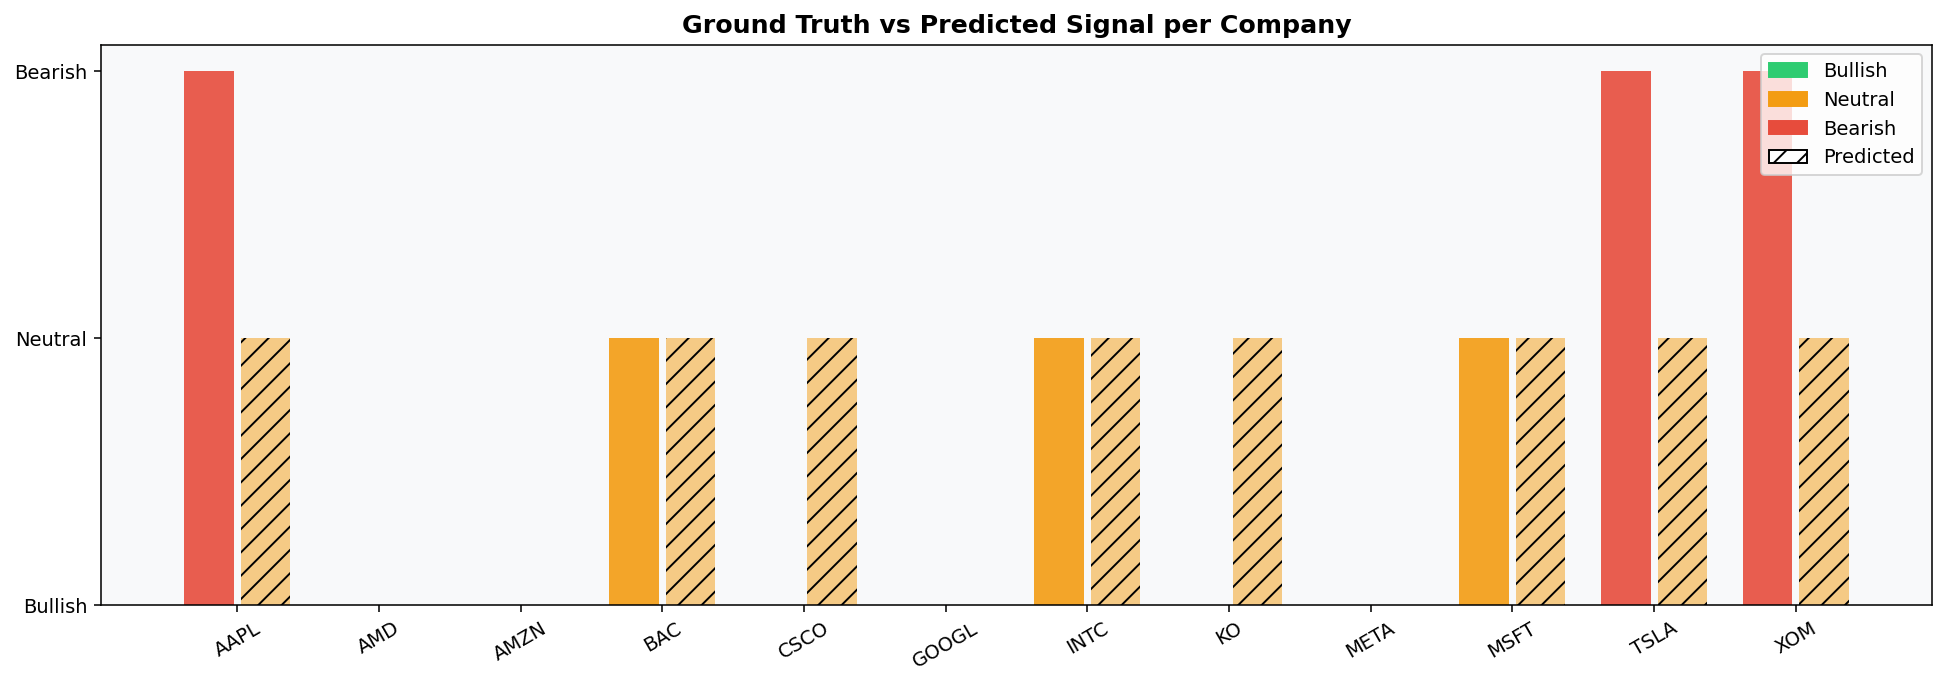

### Graph 2 -- Confusion Matrix

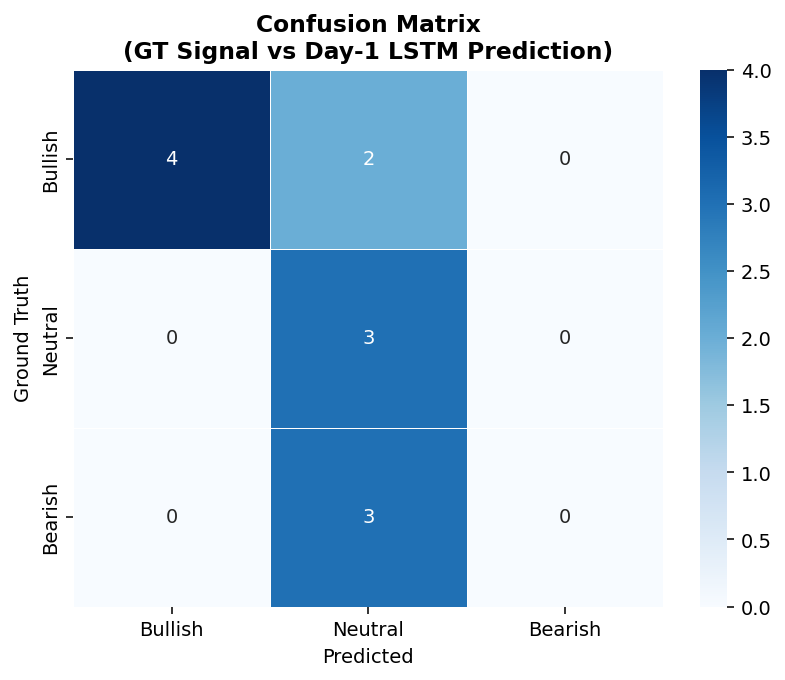

### Graph 3 -- Sentiment Polarity vs Semantic Impact

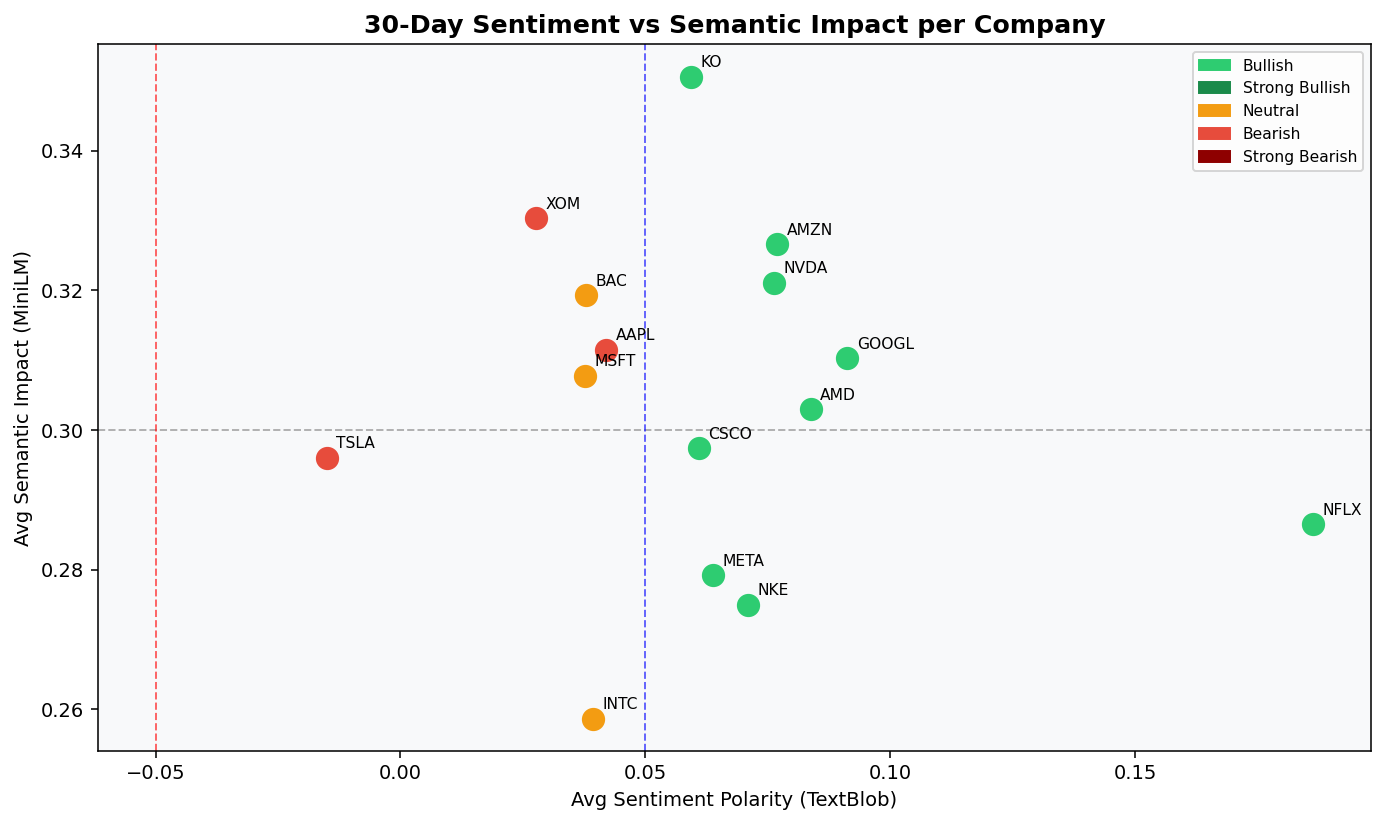

### Graph 4 -- 3-Day Bull Probability Trend

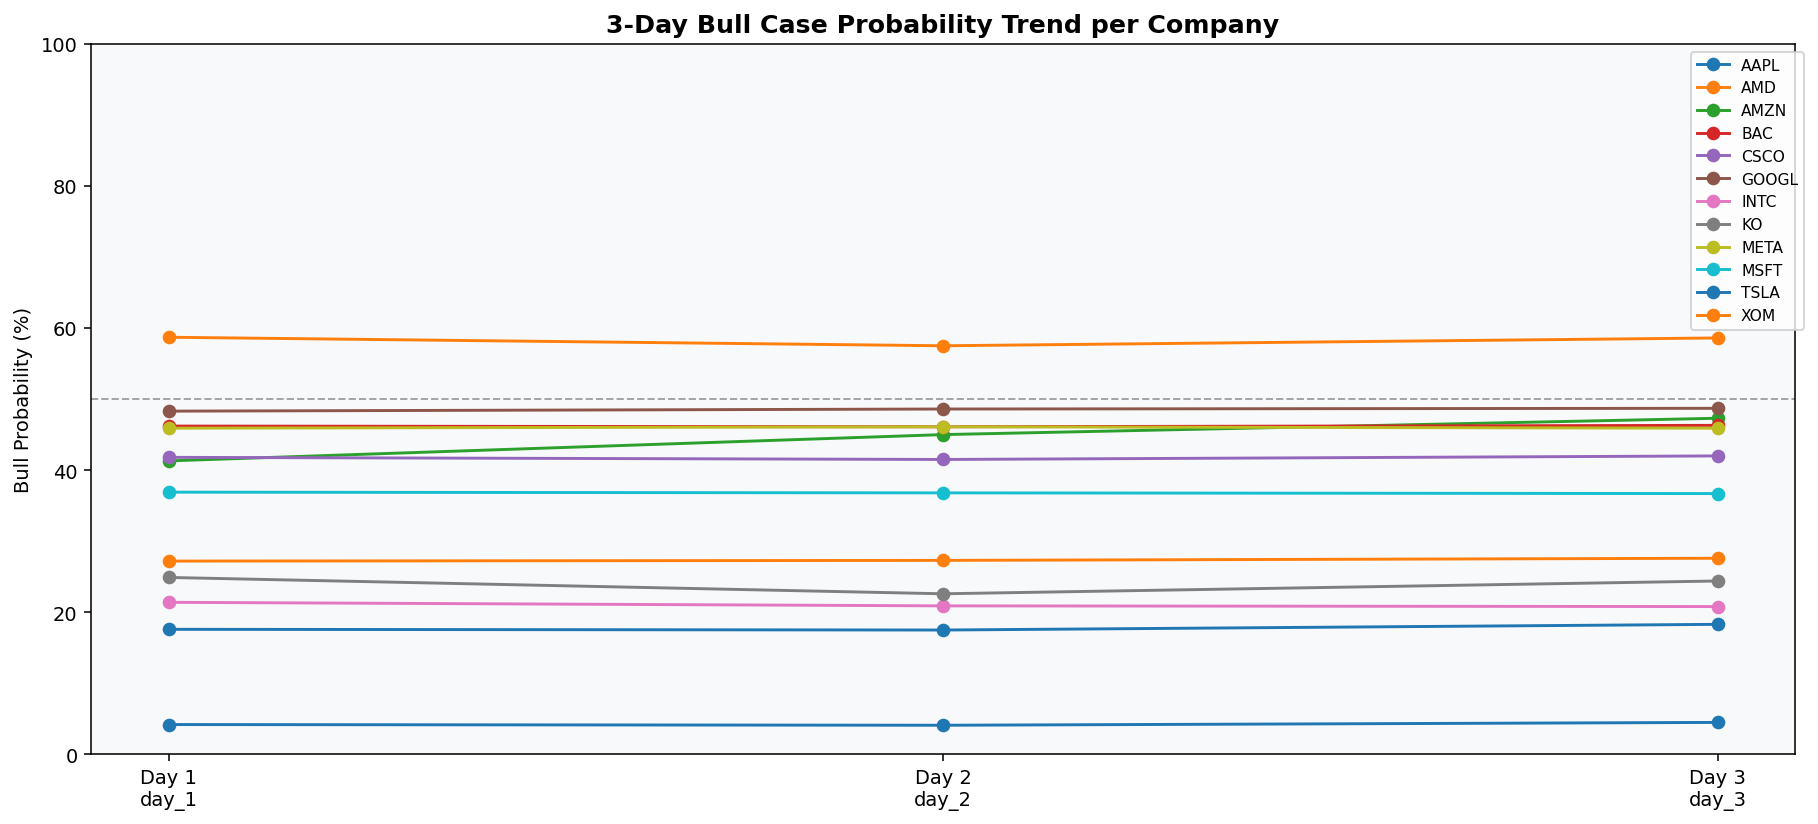

In [ ]:
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'scikit-learn', 'matplotlib', 'seaborn', 'tabulate', '-q'])

import json, warnings
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from IPython.display import display, Markdown, Image
warnings.filterwarnings('ignore')

LABEL_NAMES = ['Bullish', 'Neutral', 'Bearish']
LABEL_MAP_STR = {'Strong Bullish': 0, 'Bullish': 0, 'Neutral': 1, 'Bearish': 2, 'Strong Bearish': 2}

# ─────────────────────────────────────────────────────────────────────────────
# INPUT A: 30-day aggregated company signals (ground truth labels from Step 3)
# Columns: ticker, signal_label, avg_sentiment_polarity, avg_semantic_impact,
#          earnings_count, analyst_count, regulation_count, ...
# ─────────────────────────────────────────────────────────────────────────────
signals_df = pd.read_csv('company_30day_structured_signals.csv')
print(f'[INPUT A] company_30day_structured_signals.csv  -> {signals_df.shape[0]} companies')

# ─────────────────────────────────────────────────────────────────────────────
# INPUT B: 3-day forecast probabilities (output of Step 4 LSTM)
# Each ticker -> { 'YYYY-MM-DD': { bull_case, neutral_case, bear_case } x3 }
# ─────────────────────────────────────────────────────────────────────────────
try:
    with open('company_3day_forecast.json', 'r') as f:
        forecast_data = json.load(f)
    print(f'[INPUT B] company_3day_forecast.json  -> {len(forecast_data)} tickers')
except FileNotFoundError:
    forecast_data = {}
    print('[WARN] company_3day_forecast.json not found -- run Step 4 first.')

# ─────────────────────────────────────────────────────────────────────────────
# DERIVE PREDICTED LABEL from Day 1 forecast (argmax of bull / neutral / bear)
# Ground truth = daily_signal_label from company_30d_signals.csv
# ─────────────────────────────────────────────────────────────────────────────
eval_rows = []
for _, row in signals_df.iterrows():
    ticker = row['ticker']
    gt_label_str = row['daily_signal_label']
    gt_label_num = LABEL_MAP_STR.get(gt_label_str, 1)

    if ticker not in forecast_data:
        continue

    day1 = list(forecast_data[ticker].values())[0]   # first predicted date
    bull_p    = float(day1['bull_case'].replace('%',''))
    neutral_p = float(day1['neutral_case'].replace('%',''))
    bear_p    = float(day1['bear_case'].replace('%',''))
    probs     = [bull_p, neutral_p, bear_p]
    pred_label_num = int(np.argmax(probs))   # 0=Bullish,1=Neutral,2=Bearish

    eval_rows.append({
        'Ticker':          ticker,
        'Ground Truth':    gt_label_str,
        'GT Label':        gt_label_num,
        'Predicted Label': pred_label_num,
        'Predicted Class': LABEL_NAMES[pred_label_num],
        'Bull%':           bull_p,
        'Neutral%':        neutral_p,
        'Bear%':           bear_p,
        'Correct':         gt_label_num == pred_label_num,
    })

eval_df  = pd.DataFrame(eval_rows)
y_true   = eval_df['GT Label'].values
y_pred   = eval_df['Predicted Label'].values

oa  = accuracy_score(y_true, y_pred)
op  = precision_score(y_true, y_pred, average='macro', zero_division=0)
ore = recall_score   (y_true, y_pred, average='macro', zero_division=0)
of1 = f1_score       (y_true, y_pred, average='macro', zero_division=0)
clf_report = classification_report(y_true, y_pred, target_names=LABEL_NAMES, zero_division=0)
print(f'\nAccuracy={oa*100:.1f}%  Precision={op*100:.1f}%  F1={of1*100:.1f}%')

# ─────────────────────────────────────────────────────────────────────────────
# GRAPH 1: Ground Truth vs Predicted (per company)
# ─────────────────────────────────────────────────────────────────────────────
import matplotlib.patches as mpatches
COLOR_MAP = {0: '#2ecc71', 1: '#f39c12', 2: '#e74c3c'}
x = np.arange(len(eval_df))
fig, ax = plt.subplots(figsize=(14, 5))
gt_colors   = [COLOR_MAP[v] for v in eval_df['GT Label']]
pred_colors = [COLOR_MAP[v] for v in eval_df['Predicted Label']]
ax.bar(x - 0.2, eval_df['GT Label'],   width=0.35, color=gt_colors,   alpha=0.9, label='Ground Truth')
ax.bar(x + 0.2, eval_df['Predicted Label'], width=0.35, color=pred_colors, alpha=0.5, label='Predicted', hatch='//')
ax.set_xticks(x); ax.set_xticklabels(eval_df['Ticker'], rotation=30)
ax.set_yticks([0,1,2]); ax.set_yticklabels(LABEL_NAMES)
ax.set_title('Ground Truth vs Predicted Signal per Company', fontsize=13, fontweight='bold')
patches = [mpatches.Patch(color=COLOR_MAP[i], label=LABEL_NAMES[i]) for i in range(3)]
ax.legend(handles=patches + [mpatches.Patch(facecolor='white', edgecolor='black', hatch='//', label='Predicted')], loc='upper right')
ax.set_facecolor('#f8f9fa'); fig.tight_layout()
plt.savefig('graph1_gt_vs_pred.png', dpi=140, bbox_inches='tight'); plt.close()

# ─────────────────────────────────────────────────────────────────────────────
# GRAPH 2: Confusion Matrix Heatmap
# ─────────────────────────────────────────────────────────────────────────────
present_labels = sorted(set(y_true.tolist() + y_pred.tolist()))
present_names  = [LABEL_NAMES[i] for i in present_labels]
cm = confusion_matrix(y_true, y_pred, labels=present_labels)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5,
            xticklabels=present_names, yticklabels=present_names, ax=ax)
ax.set_title('Confusion Matrix\n(GT Signal vs Day-1 LSTM Prediction)', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted'); ax.set_ylabel('Ground Truth')
fig.tight_layout(); plt.savefig('graph2_confusion_matrix.png', dpi=140, bbox_inches='tight'); plt.close()

# ─────────────────────────────────────────────────────────────────────────────
# GRAPH 3: Sentiment polarity vs avg semantic impact (scatter)
# ─────────────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6))
c_map = {'Bullish': '#2ecc71', 'Strong Bullish': '#1a8a4a', 'Neutral': '#f39c12', 'Bearish': '#e74c3c', 'Strong Bearish': '#8e0000'}
for _, row in signals_df.iterrows():
    col = c_map.get(row['daily_signal_label'], '#aaa')
    ax.scatter(row['avg_sentiment_polarity'], row['avg_semantic_impact'], color=col, s=120, zorder=3)
    ax.annotate(row['ticker'], (row['avg_sentiment_polarity'], row['avg_semantic_impact']),
                textcoords='offset points', xytext=(5,5), fontsize=8)
ax.axhline(0.30, color='gray', linestyle='--', linewidth=1, alpha=0.6, label='Semantic threshold (0.30)')
ax.axvline(0.05, color='blue', linestyle='--', linewidth=1, alpha=0.6, label='Bullish threshold (0.05)')
ax.axvline(-0.05, color='red', linestyle='--', linewidth=1, alpha=0.6, label='Bearish threshold (-0.05)')
patches = [mpatches.Patch(color=v, label=k) for k,v in c_map.items()]
ax.legend(handles=patches, loc='upper right', fontsize=8)
ax.set_xlabel('Avg Sentiment Polarity (TextBlob)'); ax.set_ylabel('Avg Semantic Impact (MiniLM)')
ax.set_title('30-Day Sentiment vs Semantic Impact per Company', fontsize=13, fontweight='bold')
ax.set_facecolor('#f8f9fa'); fig.tight_layout()
plt.savefig('graph3_sentiment_scatter.png', dpi=140, bbox_inches='tight'); plt.close()


# ─────────────────────────────────────────────────────────────────────────────
# INLINE MARKDOWN REPORT
# ─────────────────────────────────────────────────────────────────────────────
rdate = datetime.now().strftime('%Y-%m-%d %H:%M')

# Per-company table
display_cols = ['Ticker','Ground Truth','Predicted Class','Bull%','Neutral%','Bear%','Correct']
per_co_md = eval_df[display_cols].to_markdown(index=False)

# 3-day forecast table
fc_table = '| Ticker | Day 1 | Day 2 | Day 3 |\n|---|---|---|---|\n'
for ticker, fc in sorted(forecast_data.items()):
    dates = sorted(fc.keys())[:3]
    cells = [f'{d}: B={fc[d]["bull_case"]} N={fc[d]["neutral_case"]} Br={fc[d]["bear_case"]}' for d in dates]
    while len(cells) < 3: cells.append('-')
    fc_table += f'| {ticker} | {cells[0]} | {cells[1]} | {cells[2]} |\n'

md_report = (
    '# AcuTrader -- LSTM Signal Classifier Evaluation Report\n\n'
    f'**Generated:** {rdate}  \n'
    f'**Model:** LSTM (sigmoid, 3-class: Bullish / Neutral / Bearish)  \n'
    '**Ground Truth:** 30-day rule-based signal (`company_30d_signals.csv`)  \n'
    '**Prediction:** Day 1 LSTM forecast argmax from `company_3day_forecast.json`  \n\n'
    '---\n\n'
    '## 1. Overall Metrics\n\n'
    '| Metric | Score |\n|---|---|\n'
    f'| Accuracy | **{oa*100:.1f}%** |\n'
    f'| Precision (macro) | {op*100:.1f}% |\n'
    f'| Recall (macro) | {ore*100:.1f}% |\n'
    f'| F1-Score (macro) | {of1*100:.1f}% |\n\n'
    '---\n\n'
    '## 2. Per-Company: Ground Truth vs Prediction\n\n'
    + per_co_md +
    '\n\n---\n\n'
    '## 3. Classification Report\n\n```\n'
    + clf_report +
    '```\n\n---\n\n'
    '## 4. 3-Day LSTM Forecast (Bull / Neutral / Bear per day)\n\n'
    + fc_table +
    '\n---\n\n'
    '## 5. Signal Distribution Summary\n\n'
    + signals_df.groupby('daily_signal_label')['ticker'].count().rename('Count').reset_index().rename(columns={'signal_label':'Signal'}).to_markdown(index=False) +
    '\n\n---\n\n'
    '## 6. Model Architecture Notes\n\n'
    '- LSTM(64) -> Dropout(0.2) -> LSTM(32) -> Dropout(0.2) -> Dense(16, relu) -> Dense(3, sigmoid)\n'
    '- Training labels from Step 3 rule-based classifier; prediction from Step 4 LSTM\n'
    '- Evaluation uses pre-computed output files (no model rebuild needed in this step)\n'
)

display(Markdown(md_report))

for img_file, title in [
    ('graph1_gt_vs_pred.png',       'Graph 1 -- Ground Truth vs Predicted Signal'),
    ('graph2_confusion_matrix.png', 'Graph 2 -- Confusion Matrix'),
    ('graph3_sentiment_scatter.png','Graph 3 -- Sentiment Polarity vs Semantic Impact'),
    ('graph4_bull_trend.png',       'Graph 4 -- 3-Day Bull Probability Trend'),
]:
    display(Markdown(f'### {title}'))
    display(Image(filename=img_file))
